# TEST

Welcome to the Natural Language Processing (NLP) and Clustering exam. In this exam, you will be applying NLP techniques to analyze a problem dataset named issue.csv. Your objective is to use clustering algorithms to extract and group similar problems together, making it easier to identify and prioritize issues that need to be solved.

Each group must have a name and description associated with it, which must be extracted automatically (not by eye). Therefore, each issue must have a cluster id, the group name and a group description (maximum 20 words).

## Dataset Columns
- **ID**: Identifier for each issue. You need to use it in order to return each issue with the cluster id, name and description.
- **Name**: Abbreviated title of the issue.
- **Reasson**: More extensive description of the problem.

We know there is noise in the data, yet all examples have to be included in some cluster. For example, a cluster for the examples that are noise.

We know that clustering is an abstract solution problem, i.e., there is no metric that says one solution is better than another. Therefore, we want you to put yourself in the role of a project manager, and this is a tool that works to extract types of problems and solve them in a more organized way.

It is appreciated to end the paper with some conclusions as to why certain algorithms with their hyperparameters have been used to arrive at the final solution.

## Framework
Only python greater than 3.7 can be used, with all machine learning frameworks associated. For example, hugging face, pandas, scikit-learn, pytorch.

## Optional work
The Machine Learning pipeline above, deploy it to a Rest API with docker on a single endpoint called /requests. This endpoint has to take as input a path of the csv of the input data and return a path with the csv of the output data.

# Imports

In [ ]:
!pip install sentence_transformers umap-learn wordcloud bertopic 

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm.auto import tqdm
import re

from sentence_transformers import SentenceTransformer
import nltk
from nltk.stem import WordNetLemmatizer
import umap
import hdbscan
import openai
from sklearn.cluster import KMeans,DBSCAN
from wordcloud import WordCloud

# Solution

## EDA 

In [5]:
df = pd.read_csv('issues.csv', sep = '|')

In [6]:
df.head()

id                         name  \
0   0        voice command feature   
1   1       expand content choices   
2   2       expand content library   
3   3  smart recommendation engine   
4   4     profile matching feature   

                                             reason;  
0  user wants to talk to the ai for recommendatio...  
1  user feels limited by the few icons and choice...  
2  user found limited recommendations, suggesting...  
3  user wants a smart engine for recommendations ...  
4  user suggests a feature to connect and match p...

In [7]:
df.rename(columns={"reason;": "reason"}, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      170 non-null    int64 
 1   name    170 non-null    object
 2   reason  170 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.1+ KB


In [9]:
# no missing values 
df.isnull().sum()

id        0
name      0
reason    0
dtype: int64

In [10]:
df["words per reason"] = df["reason"].str.split().apply(len)
df.head()

id                         name  \
0   0        voice command feature   
1   1       expand content choices   
2   2       expand content library   
3   3  smart recommendation engine   
4   4     profile matching feature   

                                              reason  words per reason  
0  user wants to talk to the ai for recommendatio...                13  
1  user feels limited by the few icons and choice...                10  
2  user found limited recommendations, suggesting...                11  
3  user wants a smart engine for recommendations ...                16  
4  user suggests a feature to connect and match p...                19

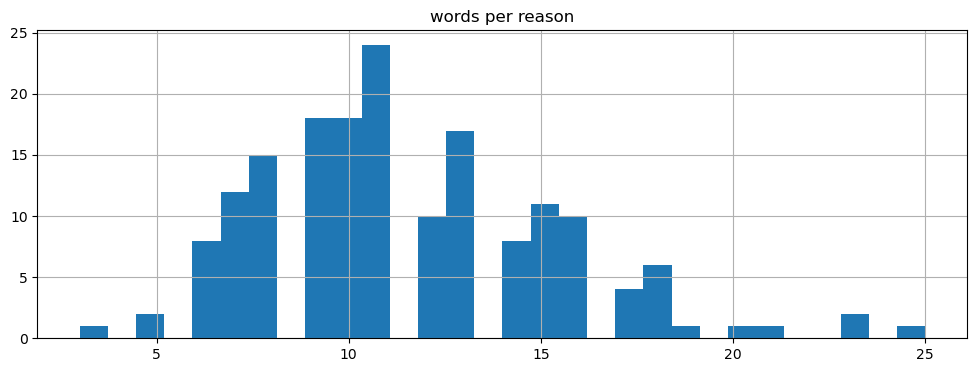

In [11]:
df.hist(column='words per reason', bins=30,figsize=(12,4));

In [12]:
print(df['name'].nunique(), df['reason'].nunique())

159 170


We combine the text from the 'name' and 'reason' columns for each row, with the intention of converting it into embeddings later.

In [13]:
df['combined_text'] = df['name'].str.cat(': ' + df['reason'])
df.head()

id                         name  \
0   0        voice command feature   
1   1       expand content choices   
2   2       expand content library   
3   3  smart recommendation engine   
4   4     profile matching feature   

                                              reason  words per reason  \
0  user wants to talk to the ai for recommendatio...                13   
1  user feels limited by the few icons and choice...                10   
2  user found limited recommendations, suggesting...                11   
3  user wants a smart engine for recommendations ...                16   
4  user suggests a feature to connect and match p...                19   

                                       combined_text  
0  voice command feature: user wants to talk to t...  
1  expand content choices: user feels limited by ...  
2  expand content library: user found limited rec...  
3  smart recommendation engine: user wants a smar...  
4  profile matching feature: user suggests a feat...

## Embedding

The first step is to embed the combined text of 'name' and 'reason' of the request using a `sentence-transformers model`. We select BAAI/bge-large-en-v1.5 as the leading model from the [Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard). This model encodes each sentence into a 1024-dimensional vector.

In [14]:
embed_model = SentenceTransformer('BAAI/bge-large-en-v1.5')
embed_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [15]:
n = len(df)
n

170

In [16]:
embeddings = embed_model.encode(df['combined_text'])

In [17]:
embeddings.shape # each sentence was converted to 1024-dimenstional vector

(170, 1024)

## UMAP (Uniform Manifold Approximation and Production) dimensionality reduction

We'll start by testing with several UMAP parameters and visualizing the results.

UMAP's main parameters:
* **n_neighbors**: This parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. This means that low values of n_neighbors will force UMAP to concentrate on very local structure (potentially to the detriment of the big picture), while large values will push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, losing fine detail structure for the sake of getting the broader of the data. The default value of n_neighbors for UMAP is 15, but we will look at values ranging from 2 (a very local view of the manifold) up to 15.
* **min_dist**: Controls how tightly UMAP is allowed to pack points together. It provides the minimum distance apart that points are allowed to be in the low dimensional representation. This means that low values of min_dist will result in clumpier embeddings. This is useful in clustering task, which is what we are doing. Larger values of min_dist will prevent UMAP from packing points together and will focus on the preservation of the broad topological structure instead. The default value for min_dist is 0.1. We will look at a range of values from 0.0 through to 0.8.

  0%|          | 0/6 [00:00<?, ?it/s]

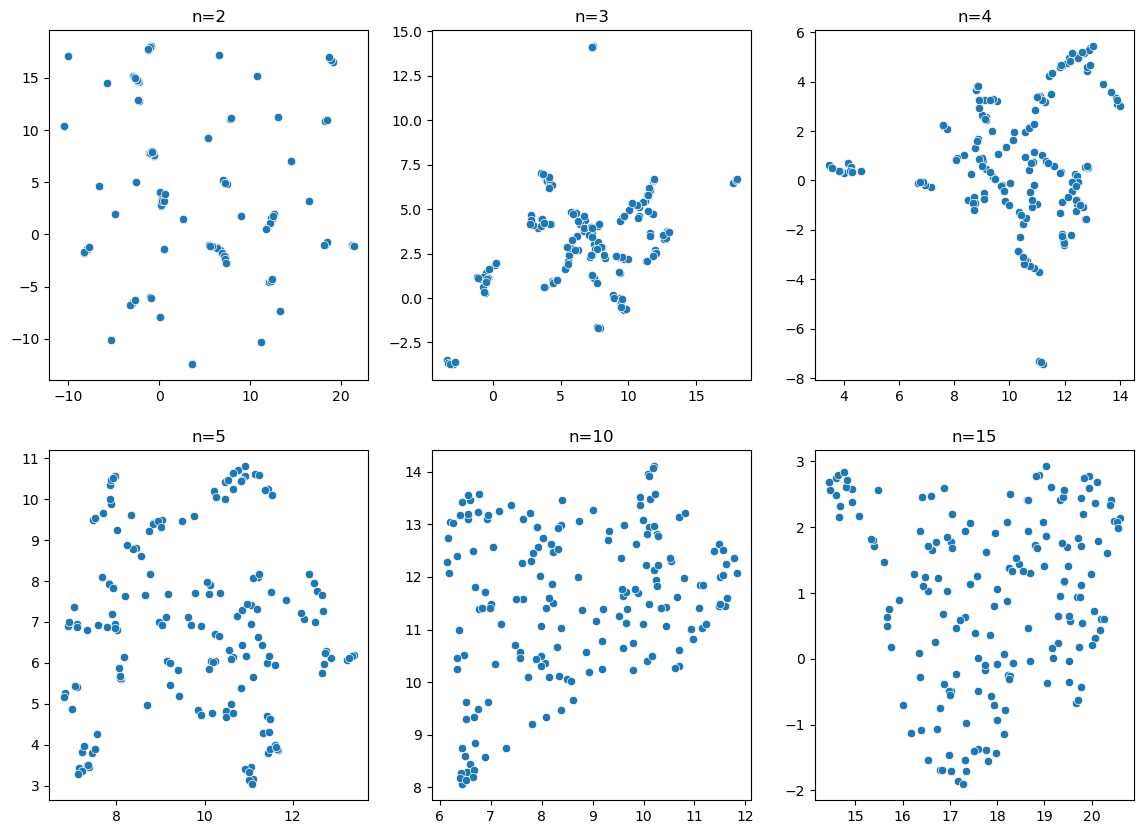

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(14, 10))
nns = [2, 3, 4, 5, 10, 15]
i, j = 0, 0
for n_neighbors in tqdm(nns):
    fit = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, random_state=1, n_jobs=1)
    u = fit.fit_transform(embeddings)
    sns.scatterplot(x=u[:,0], y=u[:,1], ax=ax[j, i])
    ax[j, i].set_title(f'n={n_neighbors}')
    if i < 2: i += 1
    else: i = 0; j += 1

  0%|          | 0/6 [00:00<?, ?it/s]

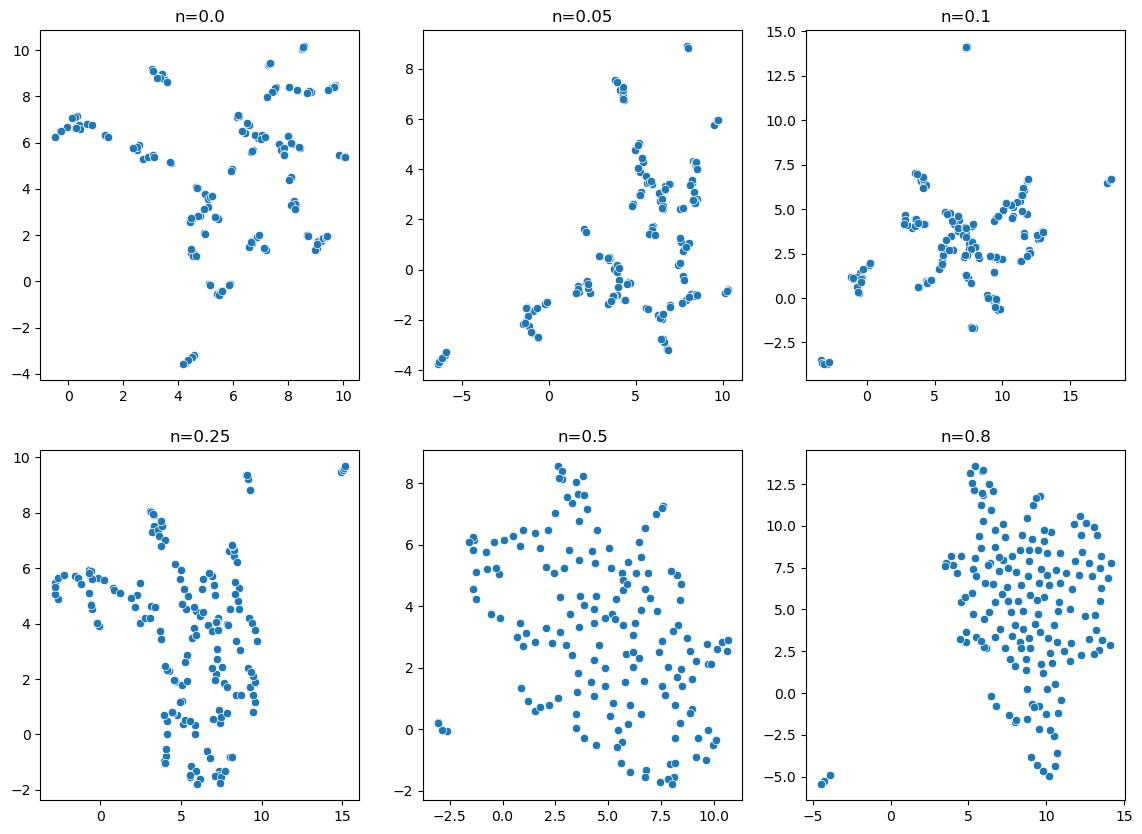

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import umap

fig, ax = plt.subplots(2, 3, figsize=(14, 10), )
min_dists = [0.0, 0.05, 0.1, 0.25, 0.5, 0.8]
i, j = 0, 0
for min_dist in tqdm(min_dists):
    fit = umap.UMAP(n_neighbors=3, min_dist=min_dist, random_state=1, n_jobs=1)
    u = fit.fit_transform(embeddings)
    sns.scatterplot(x=u[:,0], y=u[:,1], ax=ax[j, i])
    ax[j, i].set_title(f'n={min_dist}')
    if i < 2: i += 1
    else: i = 0; j += 1

One of the strongest splits seems to be using n_neighbors=3 and min_dist=0.05.


In [20]:
fit = umap.UMAP(n_neighbors=3, n_components=3, min_dist=0.05, random_state=1, n_jobs=1)
u = fit.fit_transform(embeddings)

fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    custom_data=[df['name'], df['reason']]
    )

fig.update_traces(
    hovertemplate = "<br>".join([
        "name: %{customdata[0]}",
        "reason: %{customdata[1]}"
    ]))

fig.show()

# Clustering with HDBSCAN

HDBSCAN's main parameters:
* **min_cluster_size**: the smallest size grouping that you wish to consider a cluster. The default value is 5.
* **min_samples**: The simplest intuition for what min_samples does is provide a measure of how conservative you want you clustering to be. The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas. By default is equal to min_cluster_size.


In [20]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(u)

HDBSCAN()

<Axes: ylabel='$\\lambda$ value'>

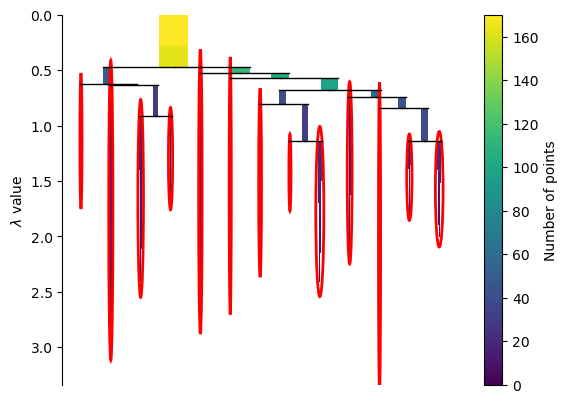

In [21]:
clusterer.condensed_tree_.plot(select_clusters = True)

With the default settings, we end up with too many clusters. I'll try increasing it to 8.

<Axes: ylabel='$\\lambda$ value'>

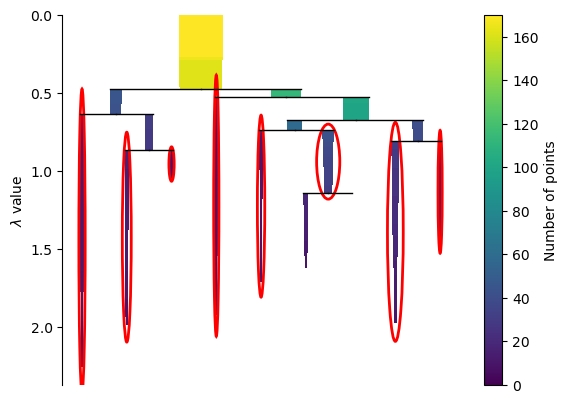

In [21]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=6)
clusterer.fit(u)
clusterer.condensed_tree_.plot(select_clusters = True)

In [22]:
colors = [str(x) for x in clusterer.labels_]

In [60]:
fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    color = colors,
    custom_data=[df['name'], df['reason']]
    )

fig.update_traces(
    hovertemplate = "<br>".join([
        "name: %{customdata[0]}",
        "reason: %{customdata[1]}"
    ]))

fig.show()

## Preparation of the prompt to the generation model

We have successfully formed our clusters and are ready to proceed with extracting their topics. To accomplish this, we need to create custom prompts for generative model tailored to each cluster. These custom prompts will include terms that are distinctively associated with a particular cluster, identified using c-TF-IDF (a modified version of TF-IDF called class-TF-IDF). c-TF-IDF finds the most relevant terms given all of the “documents” within a cluster. Additionally, we will include a selection of random documents from each cluster to enhance the accuracy of the predictions.

In [24]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(nltk.corpus.stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

def preprocess(text):
    
    # Lowercase and remove punctuation
    text = re.compile(r'[^a-zA-Z ]+').sub('', text).lower()
    
    # Tokenization
    tokens = nltk.tokenize.word_tokenize(text)
    
    # Stopword Filtering
    tokens = [token for token in tokens if token not in stopwords]
    
#     # Lemmatize the words
#     lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

[nltk_data] Downloading package punkt to /Users/victoria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victoria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/victoria/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
df.head()

id                         name  \
0   0        voice command feature   
1   1       expand content choices   
2   2       expand content library   
3   3  smart recommendation engine   
4   4     profile matching feature   

                                              reason  words per reason  \
0  user wants to talk to the ai for recommendatio...                13   
1  user feels limited by the few icons and choice...                10   
2  user found limited recommendations, suggesting...                11   
3  user wants a smart engine for recommendations ...                16   
4  user suggests a feature to connect and match p...                19   

                                       combined_text  
0  voice command feature: user wants to talk to t...  
1  expand content choices: user feels limited by ...  
2  expand content library: user found limited rec...  
3  smart recommendation engine: user wants a smar...  
4  profile matching feature: user suggests a feat...

In [26]:
df['preprocessed_text'] = df['combined_text'].apply(preprocess)
df.head()

id                         name  \
0   0        voice command feature   
1   1       expand content choices   
2   2       expand content library   
3   3  smart recommendation engine   
4   4     profile matching feature   

                                              reason  words per reason  \
0  user wants to talk to the ai for recommendatio...                13   
1  user feels limited by the few icons and choice...                10   
2  user found limited recommendations, suggesting...                11   
3  user wants a smart engine for recommendations ...                16   
4  user suggests a feature to connect and match p...                19   

                                       combined_text  \
0  voice command feature: user wants to talk to t...   
1  expand content choices: user feels limited by ...   
2  expand content library: user found limited rec...   
3  smart recommendation engine: user wants a smar...   
4  profile matching feature: user suggests a feat...   

                                   preprocessed_text  
0  [voice, command, feature, user, wants, talk, a...  
1  [expand, content, choices, user, feels, limite...  
2  [expand, content, library, user, found, limite...  
3  [smart, recommendation, engine, user, wants, s...  
4  [profile, matching, feature, user, suggests, f...

Part of c-TF-IDF requires calculating the frequency of term t in class c. For that, we need to see which tokens belong in each class. We first add the cluster/class labels to data.

In [27]:
df['cluster_id'] = clusterer.labels_
df.head()

id                         name  \
0   0        voice command feature   
1   1       expand content choices   
2   2       expand content library   
3   3  smart recommendation engine   
4   4     profile matching feature   

                                              reason  words per reason  \
0  user wants to talk to the ai for recommendatio...                13   
1  user feels limited by the few icons and choice...                10   
2  user found limited recommendations, suggesting...                11   
3  user wants a smart engine for recommendations ...                16   
4  user suggests a feature to connect and match p...                19   

                                       combined_text  \
0  voice command feature: user wants to talk to t...   
1  expand content choices: user feels limited by ...   
2  expand content library: user found limited rec...   
3  smart recommendation engine: user wants a smar...   
4  profile matching feature: user suggests a feat...   

                                   preprocessed_text  cluster_id  
0  [voice, command, feature, user, wants, talk, a...           6  
1  [expand, content, choices, user, feels, limite...           2  
2  [expand, content, library, user, found, limite...           2  
3  [smart, recommendation, engine, user, wants, s...           5  
4  [profile, matching, feature, user, suggests, f...           4

In [28]:
df['cluster_id'].value_counts()

cluster_id
 5    44
 6    30
-1    25
 2    17
 4    14
 1    12
 3    10
 0    10
 7     8
Name: count, dtype: int64

In [29]:
clusters = {label: {'tokens': []} for label in set(clusterer.labels_)}

In [30]:
clusters

{0: {'tokens': []},
 1: {'tokens': []},
 2: {'tokens': []},
 3: {'tokens': []},
 4: {'tokens': []},
 5: {'tokens': []},
 6: {'tokens': []},
 7: {'tokens': []},
 -1: {'tokens': []}}

In [31]:
for index, row in df.iterrows():
    label = row['cluster_id'] 
    tokens = row['preprocessed_text']
    
    # Update the 'tokens' list for the corresponding class in the classes dictionary
    clusters[label]['tokens'].extend(tokens)

In [ ]:
clusters[0]

{0: {'tokens': ['mark',
   'saved',
   'movies',
   'seen',
   'user',
   'requests',
   'ability',
   'mark',
   'saved',
   'movies',
   'seen',
   'flag',
   'watched',
   'content',
   'user',
   'suggests',
   'flagging',
   'already',
   'watched',
   'showsmovies',
   'mark',
   'movies',
   'watched',
   'user',
   'wants',
   'ability',
   'mark',
   'movies',
   'watched',
   'remove',
   'bookmark',
   'page',
   'content',
   'recommendation',
   'user',
   'stopped',
   'watching',
   'recommended',
   'show',
   'due',
   'political',
   'correctness',
   'remove',
   'movie',
   'recommendations',
   'user',
   'wants',
   'ability',
   'remove',
   'specific',
   'movieseries',
   'recommendations',
   'delete',
   'movies',
   'saved',
   'tab',
   'user',
   'wants',
   'ability',
   'delete',
   'movies',
   'saved',
   'tab',
   'flag',
   'watched',
   'showsmovies',
   'add',
   'ability',
   'flag',
   'already',
   'watched',
   'shows',
   'movies',
   'mark',


In [33]:
len(clusters.keys())

9

In [34]:
for c in clusters.keys():
    print(f"{c}: {len(clusters[c]['tokens'])}")

0: 99
1: 116
2: 155
3: 103
4: 149
5: 465
6: 304
7: 78
-1: 233


Create the vocabularies (both overall and cluster).

In [35]:
vocab = set()
for c in clusters.keys():
    vocab = vocab.union(set(clusters[c]['tokens']))
    clusters[c]['vocab'] = set(clusters[c]['tokens'])

In [36]:
len(vocab)

584

Get word frequency per cluster (TF).

In [37]:
tf = np.zeros((len(clusters.keys()), len(vocab)))
tf.shape

for c, _cluster in enumerate(clusters.keys()):
    for t, term in enumerate(tqdm(vocab)):
        tf[c, t] = clusters[_cluster]['tokens'].count(term)

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

In [38]:
tf.shape

(9, 584)

Now calculate IDF (which tells us how common a term is). Rare terms signify greater relevance than common terms (and will output a greater IDF score).

In [39]:
idf = np.zeros((1, len(vocab)))

# calculate average number of words per cluster
A = tf.sum() / tf.shape[0]

for t, term in enumerate(tqdm(vocab)):
    # frequency of term t across all clusters
    f_t = tf[:,t].sum()
    # calculate IDF
    idf_score = np.log(1 + (A / f_t))
    idf[0, t] = idf_score

  0%|          | 0/584 [00:00<?, ?it/s]

In [40]:
idf.shape

(1, 584)

In [41]:
tf_idf = tf*idf

In [42]:
tf_idf

array([[0.        , 0.        , 0.        , ..., 0.        , 5.2476087 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.2476087 ],
       [3.87697137, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [3.87697137, 9.11941562, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 4.55970781, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 4.55970781, ..., 0.        , 0.        ,
        0.        ]])

In [43]:
# Get the top 10 most common words per class
n = 10

top_idx = np.argpartition(tf_idf, -n)[:, -n:]
top_idx

array([[568,  22, 253, 565, 449, 515,   3, 273, 242, 523],
       [187,  64, 167, 256, 399, 350, 126, 435, 305, 138],
       [195, 334, 241, 513, 418, 381, 325, 321, 572, 447],
       [314, 206, 491, 189, 181, 388, 325, 395, 209, 159],
       [385, 359, 254, 446, 367, 236, 274,  52, 445, 268],
       [368,  41,  67,  87, 322, 454, 456, 235, 154, 385],
       [ 49, 116, 557, 197,   3, 505, 456, 236,  28, 302],
       [ 41, 373,   3, 574,  85, 239,  33, 471,  28, 332],
       [486, 131, 456, 202, 524,  55, 516, 311, 500,  38]])

Now we create a disctionary with cluster label as a key and top 10 most common words per class from c-TF-IDF step and 5 random sentences from each cluster as values.   

In [44]:
vlist = list(vocab)
data = {}

# A function to sample 5 random sentences from each cluster
def sample_sentences(group):
    return group.sample(5, random_state=42)['combined_text'].tolist()  # Set a random_state for reproducibility

for c, _cluster in enumerate(clusters.keys()):
    topn_idx = top_idx[c, :]
    topn_terms = [vlist[idx] for idx in topn_idx]
    
    # Get the sampled sentences for this cluster
    sampled_sentences = sample_sentences(df[df['cluster_id'] == _cluster])
    
    data[_cluster] = {
        'topn_terms': topn_terms,
        'sampled_sentences': sampled_sentences
    }

In [45]:
data

{0: {'topn_terms': ['showsmovies',
   'bookmark',
   'seen',
   'flag',
   'mark',
   'remove',
   'movies',
   'saved',
   'ability',
   'watched'],
  'sampled_sentences': ['bookmark disappearing: bookmark disappears after adding a movie, should stay and be filled in.;',
   'flag watched content: user suggests flagging already watched shows/movies;',
   'delete movies from saved tab: user wants the ability to delete movies from the saved tab.;',
   'mark saved movies as seen: user requests the ability to mark saved movies as seen.;',
   'mark movies as seen: add the ability to mark movies as seen and clear bookmarks;']},
 1: {'topn_terms': ['couldnt',
   'invite',
   'phone',
   'number',
   'issues',
   'receiving',
   'issue',
   'sms',
   'login',
   'code'],
  'sampled_sentences': ['sms delivery problem: user based in denmark is not receiving a response sms with the code.;',
   'login issues: user is having trouble logging in and not receiving sms with the code.;',
   'login issue

## Generation of topic and descripton for each cluster 

We will use OpenAI API to generate short label and description for each cluster.

In [46]:
prompt = """I have a topic that is described by the following keywords: {keywords} 
In this topic, the following documents are a small but representative subset of 
all documents in the topic: {documents} 
Based on the information above, please give a short label of the topic and a description of this topic 
in the following format: 
[Your Topic]: [Your Description]. 
For example: 
Login and Navigation Issues: This topic covers issues related to logging in, receiving invite codes, 
adding phone numbers, navigation problems within the app.  
Description should not exceed 20 words and should provide a concise summary."""

In [47]:
import openai

# Set up your OpenAI API key
api_key = API_KEY
openai.api_key = api_key

# Empty list to store the data
output_data = []


for _cluster, cluster_data in data.items():
    if _cluster != -1:
        keywords = ', '.join(cluster_data['topn_terms'])
        documents = ', '.join(cluster_data['sampled_sentences'])

        prompt_for_cluster = prompt.format(keywords=keywords, documents=documents)

        print(f"Class: {_cluster}")
        print(prompt_for_cluster)

        # Use OpenAI API to generate a short label and description
        response = openai.Completion.create(
            model="gpt-3.5-turbo-instruct",  
            prompt=prompt_for_cluster,
            temperature=0.3,
            max_tokens=45
        )

        generated_text = response.choices[0].text.strip()
        print("\n")
        print("Response: ")
        print(generated_text)
        print("-" * 50)

        # Assuming generated_text is in the format "topic: <description>"
        topic, description = generated_text.split(':')

        # Store the results in output_data
        output_data.append({'cluster_id': _cluster, 'group name': topic.strip(), 'group description': description.strip()})


Class: 0
I have a topic that is described by the following keywords: showsmovies, bookmark, seen, flag, mark, remove, movies, saved, ability, watched 
In this topic, the following documents are a small but representative subset of 
all documents in the topic: bookmark disappearing: bookmark disappears after adding a movie, should stay and be filled in.;, flag watched content: user suggests flagging already watched shows/movies;, delete movies from saved tab: user wants the ability to delete movies from the saved tab.;, mark saved movies as seen: user requests the ability to mark saved movies as seen.;, mark movies as seen: add the ability to mark movies as seen and clear bookmarks; 
Based on the information above, please give a short label of the topic and a description of this topic 
in the following format: 
[Your Topic]: [Your Description]. 
For example: 
Login and Navigation Issues: This topic covers issues related to logging in, receiving invite codes, 
adding phone numbers, navig



Response: 
Movie Recommendations: This topic covers issues related to receiving inaccurate, repeated, and poor movie recommendations on a platform with an AI assistant.
--------------------------------------------------
Class: 7
I have a topic that is described by the following keywords: text, shows, movies, image, ipad, accuracy, poster, show, movie, tv 
In this topic, the following documents are a small but representative subset of 
all documents in the topic: text display: texts not showing correctly (tv-show, movie);, ui issues on ipad: text size is bigger than buttons or tags, making it hard to read on ipad.;, improve matching accuracy: enhance the accuracy of movie and tv show matches in netflix.;, incorrect poster: user received a weird picture as a movie poster;, mismatched content: user gets movies when asking for tv-shows.; 
Based on the information above, please give a short label of the topic and a description of this topic 
in the following format: 
[Your Topic]: [Your D

In [48]:
cluster_name_description = pd.DataFrame(output_data)
cluster_name_description

cluster_id                               group name  \
0           0  Bookmark and Watched Content Management   
1           1                     SMS and Login Issues   
2           2      Customization and Content Expansion   
3           3                 Logo and Theme Confusion   
4           4          App Recommendations and Sharing   
5           5             User Feedback and Engagement   
6           6                    Movie Recommendations   
7           7            Text and Image Display Issues   

                                   group description  
0  This topic covers issues related to managing b...  
1  This topic covers problems with receiving SMS ...  
2  This topic covers suggestions for expanding co...  
3  This topic covers issues related to inconsiste...  
4  This topic covers features related to sharing ...  
5  This topic covers user feedback and engagement...  
6  This topic covers issues related to receiving ...  
7  This topic covers issues related to incorrect ...

In [49]:
if -1 in data:
    # Create a new DataFrame with the specified values
    outlier_row = pd.DataFrame({'cluster_id': ['-1.0'], 'group name': ['Outliers'], 'group description': ['Each problem should be analysed separately.']})

    # Concatenate the new DataFrame with the existing cluster_name_description DataFrame
    cluster_name_description = pd.concat([cluster_name_description, outlier_row],ignore_index=True)

In [50]:
cluster_name_description

cluster_id                               group name  \
0          0  Bookmark and Watched Content Management   
1          1                     SMS and Login Issues   
2          2      Customization and Content Expansion   
3          3                 Logo and Theme Confusion   
4          4          App Recommendations and Sharing   
5          5             User Feedback and Engagement   
6          6                    Movie Recommendations   
7          7            Text and Image Display Issues   
8       -1.0                                 Outliers   

                                   group description  
0  This topic covers issues related to managing b...  
1  This topic covers problems with receiving SMS ...  
2  This topic covers suggestions for expanding co...  
3  This topic covers issues related to inconsiste...  
4  This topic covers features related to sharing ...  
5  This topic covers user feedback and engagement...  
6  This topic covers issues related to receiving ...  
7  This topic covers issues related to incorrect ...  
8        Each problem should be analysed separately.

In [51]:
cluster_name_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   cluster_id         9 non-null      object
 1   group name         9 non-null      object
 2   group description  9 non-null      object
dtypes: object(3)
memory usage: 348.0+ bytes


In [52]:
cluster_name_description['cluster_id'] = cluster_name_description['cluster_id'].astype(float).round().astype('int64')

In [53]:
cluster_name_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   cluster_id         9 non-null      int64 
 1   group name         9 non-null      object
 2   group description  9 non-null      object
dtypes: int64(1), object(2)
memory usage: 348.0+ bytes


In [54]:
merged_df = pd.merge(df, cluster_name_description, on='cluster_id', how='left')

In [55]:
merged_df = merged_df[['id', 'name', 'reason', 'cluster_id', 'group name', 'group description']]
merged_df.head()

id                         name  \
0   0        voice command feature   
1   1       expand content choices   
2   2       expand content library   
3   3  smart recommendation engine   
4   4     profile matching feature   

                                              reason  cluster_id  \
0  user wants to talk to the ai for recommendatio...           6   
1  user feels limited by the few icons and choice...           2   
2  user found limited recommendations, suggesting...           2   
3  user wants a smart engine for recommendations ...           5   
4  user suggests a feature to connect and match p...           4   

                            group name  \
0                Movie Recommendations   
1  Customization and Content Expansion   
2  Customization and Content Expansion   
3         User Feedback and Engagement   
4      App Recommendations and Sharing   

                                   group description  
0  This topic covers issues related to receiving ...  
1  This topic covers suggestions for expanding co...  
2  This topic covers suggestions for expanding co...  
3  This topic covers user feedback and engagement...  
4  This topic covers features related to sharing ...

In [56]:
merged_df['cluster_id'].value_counts()

cluster_id
 5    44
 6    30
-1    25
 2    17
 4    14
 1    12
 3    10
 0    10
 7     8
Name: count, dtype: int64

In [57]:
merged_df.to_csv('output.csv', index=False)

# Explanation of the Approach

**Embedding**
* The first step was to embed the combined text of 'name' and 'reason' of the request using a `sentence-transformers model`. I selected BAAI/bge-large-en-v1.5 as the leading model from the [Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard). This model encodes each sentence into a 1024-dimensional vector.

**Dimensionality reduction**
* After obtaining the 1024-dimensional embeddings, dimensionality reduction was applied to condense the feature space to 3 dimensions. This step aimed to enhance clustering performance, particularly for density-based algorithms (DBSCAN, HDBSCAN), improve computational efficiency, and enhance interpretability.
* UMAP was selected as the clustering method due to its ability to preserve both global and local structure in the data. Unlike PCA, which primarily focuses on global structure, and t-SNE, which is more adept at preserving local structure, UMAP aims to maintain relationships between all data points, not just the nearest neighbors. Additionally, UMAP demonstrates proficiency in handling high-dimensional data and offers stability, meaning that multiple runs on the same data are more likely to yield similar results.
* n_neighbors and min_dist are main hyperparameters of UMAP. n_neighbors controls how UMAP balances local versus global structure in the data. Low values of n_neighbors will force UMAP to concentrate on very local structure and vice versa. min_dist controls how tightly UMAP is allowed to pack points together, low values of min_dist will result in clumpier embeddings what is useful for clustering tasks. After checking a range of parameters' values,  one of the strongest splits was found to be with n_neighbors=3 and min_dist=0.05.

**Clustering**
* HDBSCAN was chosen among clustering algorithms because it is a density-based algorithm that can discover clusters of varying shapes and sizes. Unlike other traditional algorithms like K-means, HDBSCAN doesn't require specifying the number of clusters in advance, making it more suitable for real-world data where the number of clusters may not be known beforehand. Additionaly, HDBSCAN is capable of identifying outliers (what is useful for noisy data like in our case). It also provides a hierarchical clustering result, allowing for the exploration of clusters at different granularities. 
* HDBSCAN's main parameters are min_cluster_size and min_samples. min_cluster_size is the smallest grouping size considered for a cluster. min_samples provide a measure of how conservative the clustering should be. The larger the value of min_samples, the more conservative the clustering will be – more points will be declared as noise. 
* With the default settings of min_cluster_size, I ended up with too many clusters. By increasing it to 8, 9 clusters were obtained. min_samples hyperparameter was reduced to 6 to make clustering a bit less conservative.

**Preparation of the prompt to the generation model**
* Clusters were successfully formed. The next step is to extract their topics. To accomplish this, I had to create custom prompts for generative model tailored to each cluster. These custom prompts will include terms that are distinctively associated with a particular cluster, identified using c-TF-IDF (a modified version of TF-IDF called class-TF-IDF). c-TF-IDF finds the most relevant terms given all of the “documents” within a cluster. Additionally, I added to the prompt a selection of random documents from each cluster to enhance the accuracy of the predictions.

**Generation of topic and descripton for each cluster**
* I used OpenAI API and the `gpt-3.5-turbo-instruct` model to generate short label and description for each cluster. I have also tried to use the flan-t5 model from Hugging Face, but it showed poorer results.

# Other Experiments

## BertTopic

In [241]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stopwords = list(stopwords.words('english'))

#We have added prediction_data=True as a new parameter to HDBSCAN. We need this to avoid an AttributeError 
# when integrating our custom HDBSCAN step with BERTopic. Adding gen_min_span_tree adds another step to 
# HDBSCAN that can improve the clusters.

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer('BAAI/bge-large-en-v1.5')

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=3, n_components=3, min_dist=0.05)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=8, min_samples=6,
                        gen_min_span_tree=True,
                        prediction_data=True)


# We must also initialize a vectorizer_model to handle stopword removal during the c-TF-IDF step. 
# We will use the list of stopwords from NLTK.

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)

In [242]:
from bertopic import BERTopic

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=10,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
topics, probs = model.fit_transform(df['combined_text'])

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

2023-11-02 20:36:32,462 - BERTopic - Transformed documents to Embeddings
2023-11-02 20:36:33,407 - BERTopic - Reduced dimensionality
2023-11-02 20:36:33,416 - BERTopic - Clustered reduced embeddings


In [240]:
result = model.get_topic_info()
result

Topic  Count                                   Name  \
0     -1     23                 -1_button_user_ai_imdb   
1      0     74                   0_user_mood_app_code   
2      1     54    1_movie_movies_recommendations_user   
3      2     19  2_category_add_categories_suggestions   

                                      Representation  \
0  [button, user, ai, imdb, content, like, rating...   
1  [user, mood, app, code, suggests, user suggest...   
2  [movie, movies, recommendations, user, seen, m...   
3  [category, add, categories, suggestions, kids,...   

                                 Representative_Docs  
0  [link imdb or apple tv account: integrate netf...  
1  [more options in mood categories: user suggest...  
2  [mark movies as watched: user wants the abilit...  
3  [suggestion for improvement: user suggests pro...

In [768]:
doc_topic = pd.DataFrame({"Topic": topics, "document": df['combined_text']})
doc_topic.head()

Topic                                           document
0      1  voice command feature: user wants to talk to t...
1      0  expand content choices: user feels limited by ...
2      0  expand content library: user found limited rec...
3      4  smart recommendation engine: user wants a smar...
4      2  profile matching feature: user suggests a feat...

In [247]:
model.visualize_topics()

In [248]:
model.visualize_barchart()

In [249]:
model.topic_representations_

{-1: [('user', 0.057394599060886335),
  ('ai', 0.04239387025586686),
  ('button', 0.04194184691032926),
  ('imdb', 0.03972862021710183),
  ('platform', 0.032844967927314915),
  ('ratings', 0.031453994656734915),
  ('like', 0.03139848029992594),
  ('assistant', 0.027641860811854074),
  ('apple', 0.027641860811854074),
  ('apple tv', 0.027641860811854074)],
 0: [('user', 0.05687497717638448),
  ('recommendation', 0.04877401027631593),
  ('home', 0.040509698244495004),
  ('feedback', 0.03506804422224752),
  ('text', 0.03356115893797859),
  ('app', 0.03322501192185522),
  ('recommendations', 0.03243618425028392),
  ('description', 0.03138519157498981),
  ('thumbs', 0.027116359830720298),
  ('based', 0.027116359830720298)],
 1: [('recommendations', 0.07655393135993582),
  ('movie', 0.04871321346693896),
  ('watch', 0.036422306113931574),
  ('suggestions', 0.03413248090580177),
  ('users', 0.033176700517219763),
  ('seen', 0.033176700517219763),
  ('movie suggestions', 0.03316104453640062),


## K-Means Clustering

In [175]:
ssd = []

for k in range(2,30):
    
    model = KMeans(n_clusters=k, n_init=10)
    
    
    model.fit(embeddings)
    
    #Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Text(0, 0.5, ' Sum of Squared Distances')

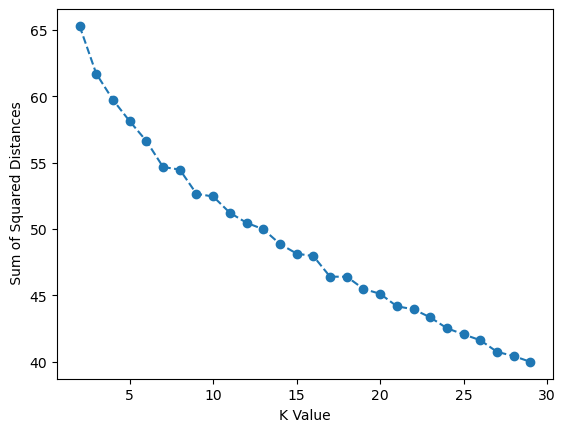

In [176]:
plt.plot(range(2,30),ssd,'o--')
plt.xlabel("K Value")
plt.ylabel(" Sum of Squared Distances")

<Axes: >

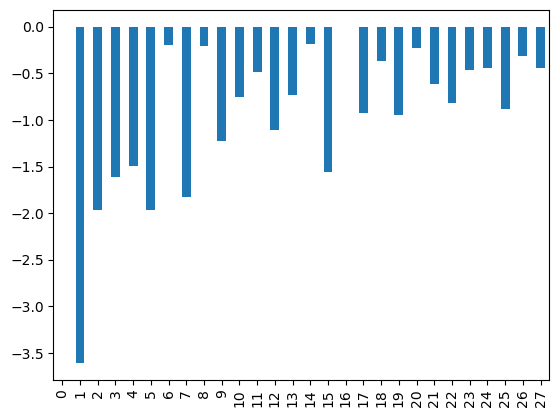

In [177]:
pd.Series(ssd).diff().plot(kind='bar')

In [178]:
k = 7
clustering_model = KMeans(n_clusters=k, n_init = 10)

In [179]:
clustering_model.fit(embeddings)

KMeans(n_clusters=7, n_init=10)

In [180]:
cluster_assignment = clustering_model.labels_
cluster_assignment

array([4, 1, 0, 0, 4, 4, 4, 0, 1, 3, 0, 2, 0, 6, 4, 3, 3, 3, 3, 1, 1, 1,
       1, 3, 2, 3, 3, 3, 3, 3, 1, 1, 0, 1, 2, 4, 3, 0, 0, 0, 4, 3, 4, 3,
       3, 5, 5, 2, 3, 2, 3, 0, 0, 0, 6, 5, 5, 4, 2, 2, 3, 3, 0, 3, 3, 0,
       3, 1, 6, 6, 5, 3, 5, 1, 6, 0, 4, 6, 0, 4, 3, 1, 3, 1, 0, 1, 0, 0,
       1, 4, 2, 0, 2, 0, 5, 0, 6, 3, 3, 4, 3, 0, 0, 4, 3, 3, 1, 0, 3, 2,
       1, 2, 0, 5, 1, 0, 0, 3, 3, 6, 5, 0, 0, 0, 5, 3, 3, 1, 1, 4, 3, 2,
       3, 2, 2, 1, 6, 2, 4, 2, 1, 5, 5, 3, 0, 5, 4, 2, 6, 6, 1, 3, 5, 1,
       2, 3, 3, 3, 5, 5, 3, 3, 5, 3, 1, 1, 3, 1, 3, 3], dtype=int32)

In [181]:
df['K Means cluster labels'] = clustering_model.labels_

In [183]:
df.head()

id                         name  \
0   0        voice command feature   
1   1       expand content choices   
2   2       expand content library   
3   3  smart recommendation engine   
4   4     profile matching feature   

                                              reason  words per reason  \
0  user wants to talk to the ai for recommendatio...                13   
1  user feels limited by the few icons and choice...                10   
2  user found limited recommendations, suggesting...                11   
3  user wants a smart engine for recommendations ...                16   
4  user suggests a feature to connect and match p...                19   

                                       combined_text  \
0  voice command feature: user wants to talk to t...   
1  expand content choices: user feels limited by ...   
2  expand content library: user found limited rec...   
3  smart recommendation engine: user wants a smar...   
4  profile matching feature: user suggests a feat...   

                                   preprocessed_text  cluster_id  \
0  [voice, command, feature, user, wants, talk, a...           6   
1  [expand, content, choices, user, feels, limite...           2   
2  [expand, content, library, user, found, limite...           2   
3  [smart, recommendation, engine, user, wants, s...           5   
4  [profile, matching, feature, user, suggests, f...           4   

   K Means cluster labels  
0                       4  
1                       1  
2                       0  
3                       0  
4                       4

In [185]:
cluster_df = pd.DataFrame(list(df['combined_text']), columns = ['text'])
cluster_df['cluster'] = clustering_model.labels_
cluster_df.head()

text  cluster
0  voice command feature: user wants to talk to t...        4
1  expand content choices: user feels limited by ...        1
2  expand content library: user found limited rec...        0
3  smart recommendation engine: user wants a smar...        0
4  profile matching feature: user suggests a feat...        4

In [186]:
cluster_df['cluster'].value_counts()

cluster
3    48
0    32
1    27
2    18
4    17
5    17
6    11
Name: count, dtype: int64

In [187]:
clustered_sentences = [[] for i in range(k)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(df['combined_text'][sentence_id])

In [188]:
for i, cluster in enumerate(clustered_sentences):
    print('Cluster ', i+1)
    print(cluster)
    print("")

Cluster  1
['expand content library: user found limited recommendations, suggesting an expansion of the content library.;', 'smart recommendation engine: user wants a smart engine for recommendations based on richer content descriptions, similar titles, and timing/mood.;', 'feature request: share recommendations: user suggests adding the ability to share recommendations with friends.;', 'user feedback interview: perform topic modeling on the user feedback interview;', 'add feedback option for recommendations: user wants the ability to provide feedback on recommendations when pressing thumbs down and selecting another one.;', 'safe cards and genre exploration: user suggests providing safe cards initially and allowing exploration of more genres based on usage.;', 'improve recommendation variety: increase the variation of recommendations provided;', 'customize recommendation algorithm: allow users to easily adapt the algorithm and tweak recommendation settings;', 'preference update issue:

In [190]:
#word cloud

def word_cloud(pred_df, label):
    wc = ' '.join([text for text in pred_df['text'][pred_df['cluster'] == label]])
    wordcloud = WordCloud(width=400, height=200, 
                         random_state=21, max_font_size=110).generate(wc)
    fig = plt.figure(figsize =(10, 7))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')

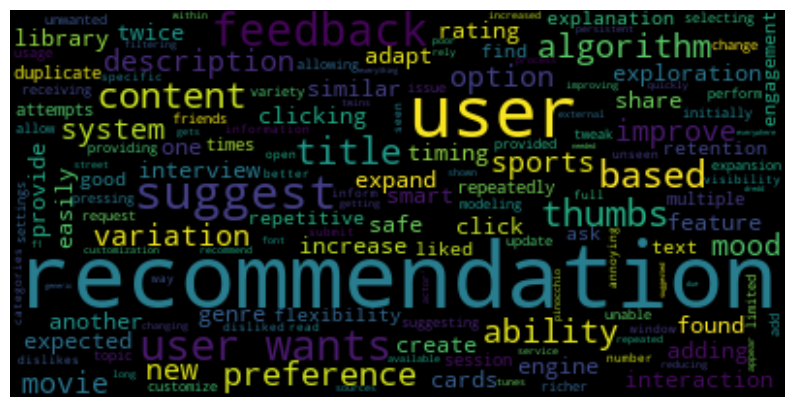

In [191]:
word_cloud(cluster_df, 0)

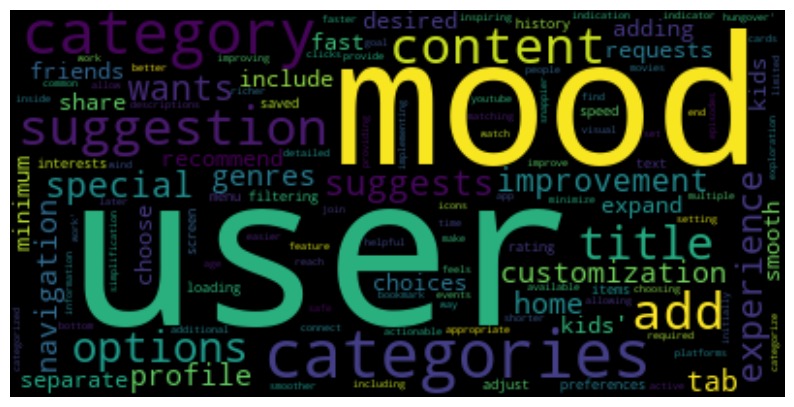

In [192]:
word_cloud(cluster_df, 1)

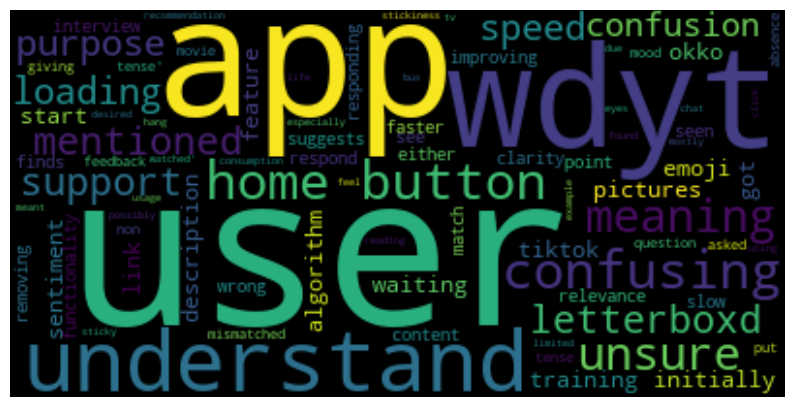

In [193]:
word_cloud(cluster_df, 2)

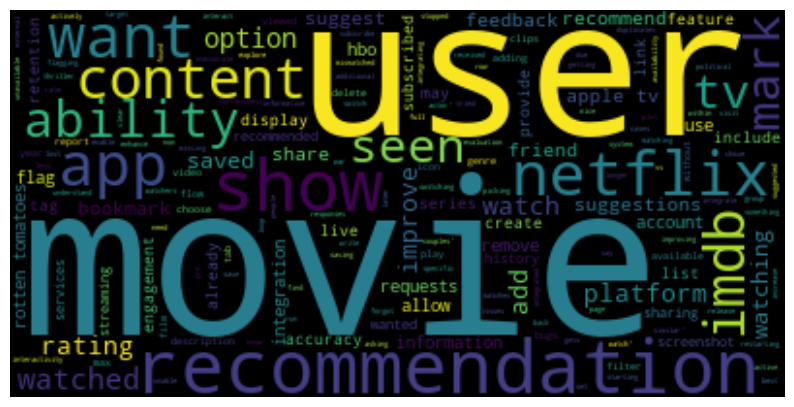

In [194]:
word_cloud(cluster_df, 3)

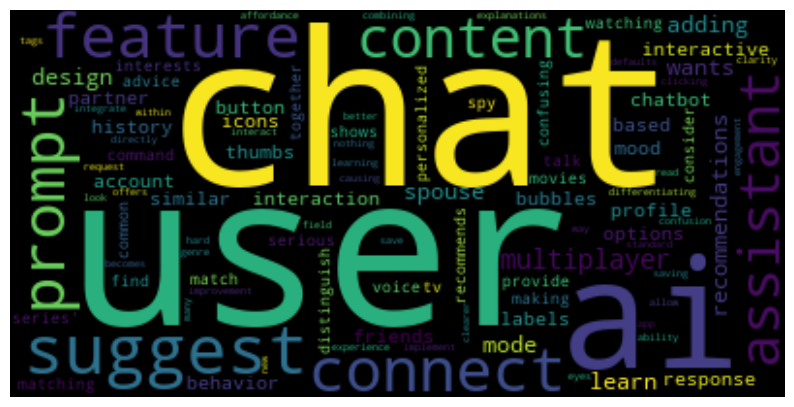

In [195]:
word_cloud(cluster_df, 4)

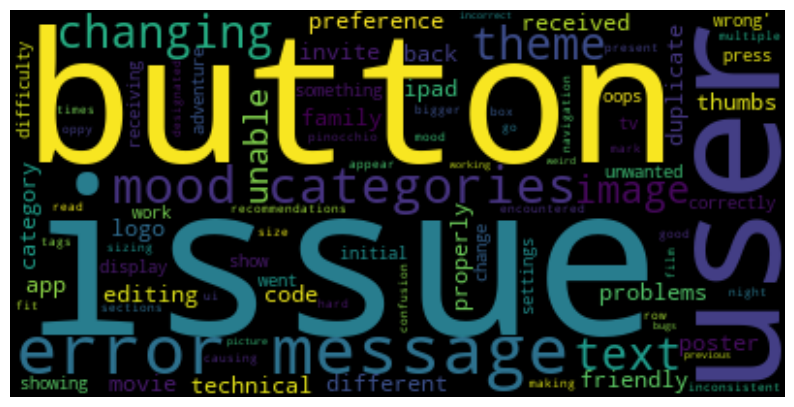

In [196]:
word_cloud(cluster_df, 5)

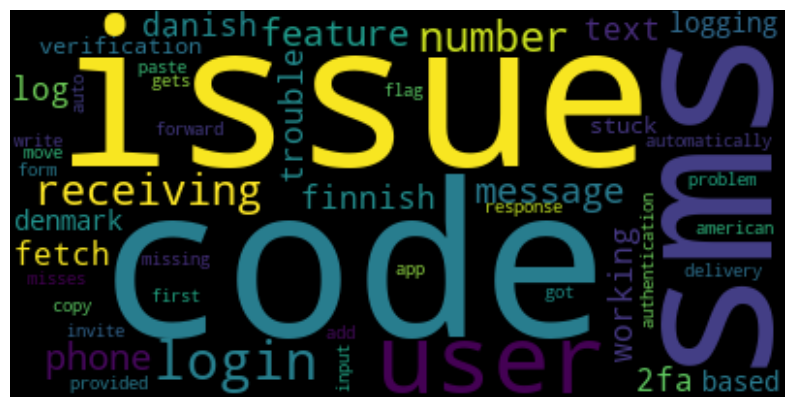

In [197]:
word_cloud(cluster_df, 6)

## UMAP

Since visualizing the hidden states in 1024 dimensions is tricky to say
the least, we’ll use the powerful UMAP algorithm to project the vectors down to 2D.

In [200]:
embeddings.shape

(170, 1024)

In [203]:
# Initialize and fit UMAP
mapper = umap.UMAP(n_components=2, metric="cosine").fit(embeddings)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = cluster_df['cluster']
df_emb.head()

X         Y  label
0  5.763893 -2.130073      4
1  4.200795 -1.880580      1
2  4.148688 -2.651610      0
3  4.976798 -2.401210      0
4  5.053829 -4.314594      4

In [205]:
cluster_df['cluster'].unique()

array([4, 1, 0, 3, 2, 6, 5], dtype=int32)

/Users/victoria/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/victoria/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/victoria/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/victoria/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



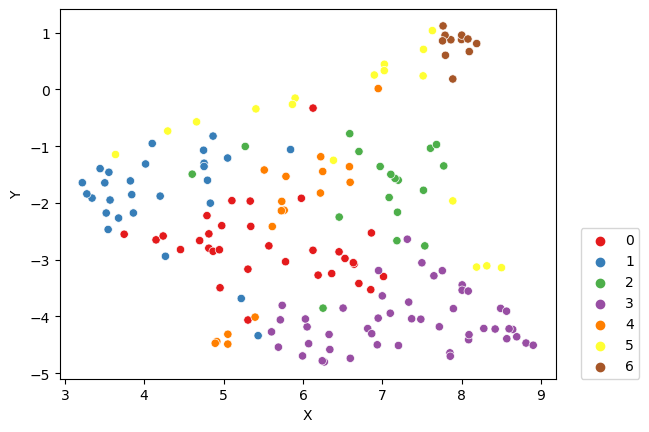

In [206]:
sns.scatterplot(x=df_emb['X'], y=df_emb['Y'], hue=df_emb["label"], palette='Set1')
plt.legend(loc=(1.05,0))

## PCA

In [207]:
from sklearn.decomposition import PCA

In [208]:
pca_model = PCA(n_components=2)

In [209]:
pca_pixels = pca_model.fit_transform(embeddings)

In [210]:
np.sum(pca_model.explained_variance_ratio_)

0.16614641

In [211]:
pca_pixels.shape[1]

2

## DBSCAN

In [213]:
from sklearn.cluster import DBSCAN

In [219]:
outlier_percent = []
outlier_amount = []

for eps in np.linspace(0.001,2,50):
    
    # Create Model
    dbscan = DBSCAN(eps=eps,min_samples=2)
    dbscan.fit(embeddings)
   
     
    # Log percentage of points that are outliers
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

/Users/victoria/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/victoria/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/victoria/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/victoria/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0.5, 0, 'Epsilon Value')

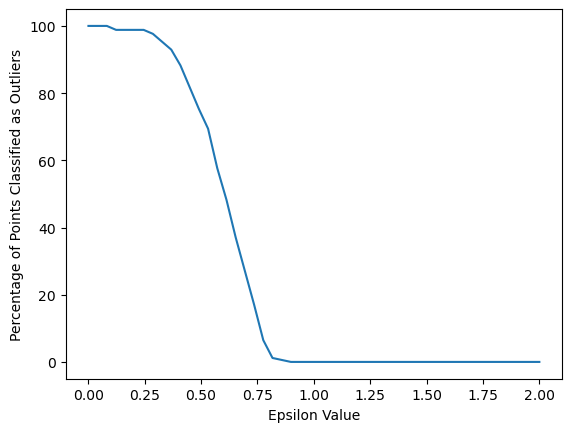

In [220]:
sns.lineplot(x=np.linspace(0.001,2,50),y=outlier_percent)
plt.ylabel("Percentage of Points Classified as Outliers")
plt.xlabel("Epsilon Value")

In [222]:
dbscan = DBSCAN(eps=0.7)
dbscan.fit(embeddings)

DBSCAN(eps=0.7)

In [227]:
df['Dbscan labels'] = dbscan.labels_

In [229]:
df['Dbscan labels'].unique()

array([-1,  0,  2,  1])

In [230]:
df.head()

id                         name  \
0   0        voice command feature   
1   1       expand content choices   
2   2       expand content library   
3   3  smart recommendation engine   
4   4     profile matching feature   

                                              reason  words per reason  \
0  user wants to talk to the ai for recommendatio...                13   
1  user feels limited by the few icons and choice...                10   
2  user found limited recommendations, suggesting...                11   
3  user wants a smart engine for recommendations ...                16   
4  user suggests a feature to connect and match p...                19   

                                       combined_text  \
0  voice command feature: user wants to talk to t...   
1  expand content choices: user feels limited by ...   
2  expand content library: user found limited rec...   
3  smart recommendation engine: user wants a smar...   
4  profile matching feature: user suggests a feat...   

                                   preprocessed_text  cluster_id  \
0  [voice, command, feature, user, wants, talk, a...           6   
1  [expand, content, choices, user, feels, limite...           2   
2  [expand, content, library, user, found, limite...           2   
3  [smart, recommendation, engine, user, wants, s...           5   
4  [profile, matching, feature, user, suggests, f...           4   

   K Means cluster labels  dbscan_labels  Dbscan labels  
0                       4             -1             -1  
1                       1              0              0  
2                       0              0              0  
3                       0              0              0  
4                       4              0              0

In [231]:
df['Dbscan labels'].value_counts()

Dbscan labels
 0    82
-1    76
 1     8
 2     4
Name: count, dtype: int64

## Tf-idf vectorization, dimensionality reduction using LSA and clustering with K-means 

In [235]:
from sklearn.feature_extraction.text import TfidfVectorizer

After ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5) and terms that are not present in at least 5 documents (set by min_df=5)

In [ ]:
#max_df=0.5, min_df=2
vectorization = TfidfVectorizer(max_df=0.5)
X_tfidf = vectorization.fit_transform(df['preprocessed_text'])

In [244]:
X_tfidf

<170x540 sparse matrix of type '<class 'numpy.float64'>'
	with 1280 stored elements in Compressed Sparse Row format>

In [245]:
# We find that around 2.5% of the entries of the X_tfidf matrix are non-zero.
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.014


In [246]:
ssd = []

for k in range(2,30):
    
    model = KMeans(n_clusters=k, n_init=10)
    
    
    model.fit(X_tfidf)
    
    #Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)

<Axes: >

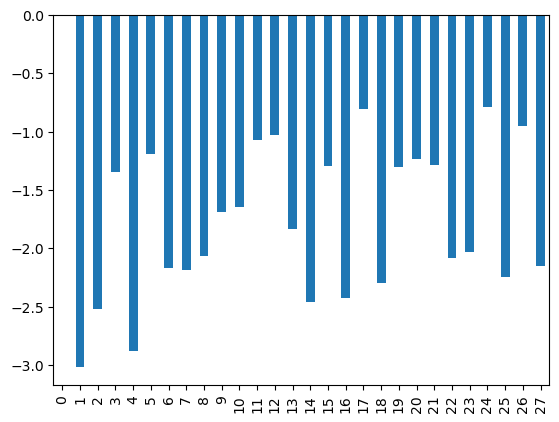

In [247]:
pd.Series(ssd).diff().plot(kind='bar')

In [248]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Explained variance of the SVD step: 84.0%


In [249]:
ssd = []

for k in range(2,30):
    
    model = KMeans(n_clusters=k, n_init=1)
    
    
    model.fit(X_lsa)
    
    #Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)

<Axes: >

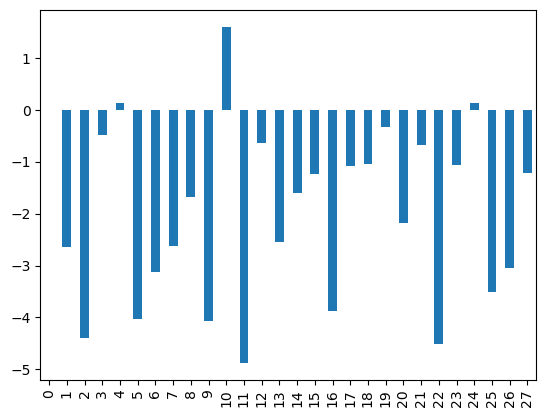

In [250]:
pd.Series(ssd).diff().plot(kind='bar')

In [260]:
k = 5
kmeans = KMeans(
    n_clusters=k,
    max_iter=100,
    n_init=1,
)

In [262]:
kmeans.fit(X_lsa)

KMeans(max_iter=100, n_clusters=5, n_init=1)

In [264]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorization.get_feature_names_out()

for i in range(k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: mood like category button feature chat suggests message adding issue 
Cluster 1: movie show mark want suggestion information title seen saved description 
Cluster 2: content app rating option feedback algorithm category special customization add 
Cluster 3: friend share wdyt recommend recommendation meaning sharing screenshot wanted content 
Cluster 4: recommendation code receiving title preference issue sm get thumb based 


In [265]:
cluster_1_df = pd.DataFrame(list(df['combined_text']), columns = ['text'])
cluster_1_df['cluster'] = kmeans.labels_
cluster_1_df

text  cluster
0    voice command feature: user wants to talk to t...        0
1    expand content choices: user feels limited by ...        2
2    expand content library: user found limited rec...        4
3    smart recommendation engine: user wants a smar...        4
4    profile matching feature: user suggests a feat...        0
..                                                 ...      ...
165  navigation indicator: add visual indication of...        0
166  alternative platform options: show options to ...        1
167  home screen text: shorter and snappier text on...        2
168  mark as viewed: add a function to mark movies ...        1
169  post-watch feedback: allow users to give feedb...        2

[170 rows x 2 columns]